### Linear Discriminant Analysis Exercise

- Following example of [this blog post](https://goelhardik.github.io/2016/10/04/fishers-lda/) and [this blog post](https://sebastianraschka.com/Articles/2014_python_lda.html#principal-component-analysis-vs-linear-discriminant-analysis)
- Algorithm summary
    - for each class $c$, calculate the within-class scatter-ness $S_c = \sum_{x\in c}^n{(x-m_c)(x-m_c)^T}$, where $m_c$ is the mean vector for all variables
    - sum all $S_i$ to get $S_W = \sum_{c=1}^{C}S_c$
    - for all classes, calcuate the between-class scatter-ness $S_B = \sum_{c=1}^{C}N_c(m_c-m)(m_c-m)^T$, where $m$ is the mean vector for the whole dataset
    - eigen-decompose the matrix $A = S_B^{-1}S_W$, and pick the top $K$ eigen-vectors. these are the new reduced dimensions for the original dataset
    - transform the original dataset using the new dimensions, $X_{new}= XW$, where $W$ is the top $K$ eigen vectors

In [1]:
class LDA():
    def __init__(self, dims=2):
        '''
        class builder for LDA
        X: input dataset
        y: labels (classes) of the data
        dims: number of new dimensions
        '''
        self.dims = dims
        
    def calc_scatter(self, X, y):
        c_means = {c: X[y==c, :].mean(axis=0) for c in self.classes}
        means = X.mean(axis=0)
        
        # initialize empty m x m matrix for the between-class scatter-ness
        self.Sb = np.zeros((self.m, self.m))
        # initialize empty m x m matrix for the within-class scatter-ness
        self.Sw = np.zeros((self.m, self.m))
        # initialize prior distribution of classes (pct of each class)
        self.class_prior = {}
        for k, v in c_means.items():
            # calcluate between-class scatter-ness
            cn = (y==k).sum()
            self.class_prior[k] = cn / self.n
            self.Sb += cn * np.outer((c_means[k] - means), (c_means[k] - means))
            #calculate within-class scatter-ness
            self.Sw += (X[y==k, :] - v).T.dot(X[y==k, :] - v)

    def fit(self, X, y):
        # assign variables
        self.n, self.m = X.shape
        self.classes = np.unique(y)
        # calcualte between-class and within-class scatter-ness
        self.calc_scatter(X, y)
        # calcualte matrix A, the targe to eigen-decompose
        A = np.linalg.inv(self.Sw).dot(self.Sb)
        # eigen decompose using numpy function
        eigvals, eigvecs = np.linalg.eig(A)
        # pair eigen values and corresponding eigen vectors
        eiglist = [(eigvals[i], eigvecs[:, i]) for i in range(len(eigvals))]
        # sort eigen vectors in desc by eigen values
        eiglist = sorted(eiglist, key=lambda x: x[0], reverse=True)
        self.W = np.array([eiglist[i][1] for i in range(self.dims)]).T
        # transform the original input data using the top K=2 eigen vectors
        self.X_new = X.dot(self.W)
    
        # calculate the new means per class for the transformed data
        self.means_new_class = {c: self.X_new[y==c,:].mean(axis=0) for c in self.classes}
        # calculate covariance matrix for each class
        self.cov_new_class = {c: np.cov(self.X_new[y==c,:], rowvar=False) for c in self.classes}
        
    def gaussian(self, point):
        # initialize empty array to hold likelihood per class
        pdf = np.zeros(len(self.classes))
        # transform new data point
        point_new = point.dot(self.W)
        # calculate the normal likelihood per class for the transformed data point
        for i, c in enumerate(self.classes):
            cov = self.cov_new_class[c]
            means = self.means_new_class[c]
            cons = 1. / ((2*np.pi)**(len(point_new) / 2.)) * (np.linalg.det(cov)**(-0.5))
            exp = np.exp(-0.5*(point_new - means).T.dot(np.linalg.inv(cov)).dot((point_new - means)))
            pdf[i] = cons * exp
        return pdf
    
    def predict(self, data):
        # initialize prediction matrix
        preds = np.zeros((data.shape[0], len(self.classes)))
        # loop through each row in the new data set and calculate likelihood per class
        for n in range(data.shape[0]):
            for i, c in enumerate(self.classes):
                preds[n, i] = (self.gaussian(data[n, :])[i] * self.class_prior[c])
        # return the label correpsonding to the most likely class
        return np.array([self.classes[p] for p in preds.argmax(axis=1)])

In [2]:
# load test data

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)
df[4] = df[4].map({'Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2})
df.tail()

,0,1,2,3,4
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2
149,5.9,3.0,5.1,1.8,2


In [3]:
lda = LDA()
X, y = df.iloc[:, 0:3].values, df.iloc[:, 4].values
lda.fit(X, y)

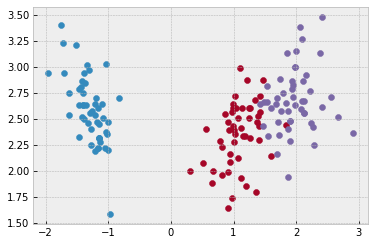

In [9]:
for i, c in enumerate(colors):
    plt.scatter(lda.X_new[y==i, 0],lda.X_new[y==i, 1])

In [10]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y, lda.predict(X))

array([[50,  0,  0],
       [ 0, 48,  2],
       [ 0,  3, 47]])